In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import geopandas
import numpy as np
import sqlalchemy as sa
import re
import dateutil
import pudl
import pathlib
import zipfile
import pickle

In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set()
%matplotlib inline

In [5]:
#plt.style.use('ggplot')
mpl.rcParams['figure.figsize'] = (20,8)
mpl.rcParams['figure.dpi'] = 150
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

In [6]:
import logging
import sys
logger = logging.getLogger()
logger.setLevel(logging.INFO)
handler = logging.StreamHandler(stream=sys.stdout)
log_format = '%(asctime)s [%(levelname)8s] %(name)s:%(lineno)s %(message)s'
formatter = logging.Formatter(log_format)
handler.setFormatter(formatter)
logger.handlers = [handler]

In [222]:
pudl_settings = pudl.workspace.setup.get_defaults()
ferc1_engine = sa.create_engine(pudl_settings['ferc1_db'])
pudl_engine = sa.create_engine(pudl_settings['pudl_db'])
pudl_settings

{'pudl_in': '/home/zane/code/catalyst/pudl-work',
 'data_dir': '/home/zane/code/catalyst/pudl-work/data',
 'settings_dir': '/home/zane/code/catalyst/pudl-work/settings',
 'pudl_out': '/home/zane/code/catalyst/pudl-work',
 'sqlite_dir': '/home/zane/code/catalyst/pudl-work/sqlite',
 'parquet_dir': '/home/zane/code/catalyst/pudl-work/parquet',
 'datapkg_dir': '/home/zane/code/catalyst/pudl-work/datapkg',
 'notebook_dir': '/home/zane/code/catalyst/pudl-work/notebook',
 'ferc1_db': 'sqlite:////home/zane/code/catalyst/pudl-work/sqlite/ferc1.sqlite',
 'pudl_db': 'sqlite:////home/zane/code/catalyst/pudl-work/sqlite/pudl.sqlite'}

# Remaining Tasks

## Historical Geometries

### Integrate Planning Area Descriptions
* Given that all of the reported FERC 714 demand has an EIA entity of some kind associated with it, the task now is to see how those EIA entities can be hooked up with the county-level service areas reported in the EIA 861
* Could also check to see how well they correspond to the utility IDs that are listed in the HIFLD 2018 utility service area and balancing area maps -- I'm starting to wonder if those are all ust amalgamations of counties based onthe EIA 861 data?
* To check these FERC respondent associated `eia_code` values against the EIA 861 we need to get that data integrated into PUDL (at least extract and transform for a couple of tables).
* Then, for each demand reporting FERC respondent, look up their `eia_code` in the service territory table. If it's not there, look it up in the Balancing Authority table (which goes away in 2013) and collect a list of constituent utilities from the balancing area table for which to grab county names out of the service area table.
* Seems like this means creating a function that given an EIA Utility ID, goes and finds all the counties associated with it.
* Then we need to map those state and county names to the FIPS county codes.
* If there are any FERC respondents whose corresponding `eia_code` values show up in neither the BA or service territory tables of EIA 861, then we'll need to do the string matching (but why would a utility not show up in either of those?)

## Demand Time Series

### Revise timezone assignments
* Drop duplicate times (there are only a half-dozen of them now)
* Ensure that the DatetimeIndex is complete for the entire span of time that each respondent is reporting.

### Find broken data:
* Run Tyler Ruggles' anomaly detection code as improved by Greg Schivley
* What kind of anomalies are we finding? Are they a problem? What portion of the overall dataset do they represent?

### Repair data:
* How do we want to fill in the gaps?
* Ideally would be able to use the MICE technique that Tyler used, but we need to keep it all in Python.
* Can do much simpler rolling averages or something for the moment when there are small gaps just to have completeness.
* Should make this gap filling process modular -- use different techniques and see whether they do what we need.

In [8]:
%%time
import pudl.transform.eia861
with pathlib.Path("raw_dfs_eia861.pkl").open(mode="rb") as f:
    raw_eia861 = pickle.load(f)
tfr_eia861 = pudl.transform.eia861.service_territory(raw_eia861, {})
svc_terr = tfr_eia861["service_territory_eia861"]

2020-05-10 09:02:31,793 [    INFO] pudl.helpers:46 Assigned state FIPS codes for 100.00% of records.
2020-05-10 09:02:34,877 [    INFO] pudl.helpers:53 Assigned county FIPS codes for 99.88% of records.
2020-05-10 09:02:34,937 [    INFO] pudl.helpers:913 Converting the dtypes of: service_territory_eia861
CPU times: user 7.29 s, sys: 0 ns, total: 7.29 s
Wall time: 7.36 s


In [15]:
raw_sales_eia861 = raw_eia861["sales_eia861"]

## EIA 861 Sales Transform Function:

### Structural
* Remove invalid rows
  * utility_id_eia is NULL
  * utility_id_eia is in bad IDs.
* Post-transform natural primary keys:
  * `["report_year", "utility_id_eia", "state", "part", "ba_code"]`
* Three kinds of data Columns:
  * Customers (number of them, int)
  * Sales (MWh, Float)
  * Revenues (USD, Float)
  
### Data Type Compatability


In [ ]:
def sales(raw_dfs, tfr_dfs):
    """Transform the EIA 861 Sales table."""
    # Structural fixes
    # Ensure dtype compatibility
    

In [217]:
idx_cols = ["utility_id_eia", "state", "report_year", "part", "ba_code"]
customer_classes = ["commercial", "industrial", "other", "residential", "total", "transportation"]

def filter_customer_cols(df, customer_classes):
    regex = f"^({'_|'.join(customer_classes)}).*$"
    return df.filter(regex=regex)

def filter_non_customer_cols(df, customer_classes):
    regex = f"^(?!({'_|'.join(customer_classes)})).*$"
    return df.filter(regex=regex)

# Clean up the values just enough to use the primary key columns as a multi-index:
raw_sales = (
    raw_sales_eia861.copy()
    .assign(ba_code=lambda x: x.ba_code.fillna("UNK"))
    .dropna(subset=["utility_id_eia"])
    .query("utility_id_eia not in (88888, 99999)")
    .astype({"utility_id_eia": pd.Int64Dtype()})
    .set_index(idx_cols)
)

data_cols = raw_sales.pipe(filter_customer_cols, customer_classes)
data_cols.columns = data_cols.columns.str.split("_", n=1, expand=True)
denorm_cols = raw_sales.pipe(filter_non_customer_cols, customer_classes)

# Now we need to take the data columns and melt the customer classes into categories.

MultiIndex([(    'commercial', 'customers'),
            (    'commercial',  'revenues'),
            (    'commercial', 'sales_mwh'),
            (    'industrial', 'customers'),
            (    'industrial',  'revenues'),
            (    'industrial', 'sales_mwh'),
            (         'other', 'customers'),
            (         'other',  'revenues'),
            (         'other', 'sales_mwh'),
            (   'residential', 'customers'),
            (   'residential',  'revenues'),
            (   'residential', 'sales_mwh'),
            (         'total', 'customers'),
            (         'total',  'revenues'),
            (         'total', 'sales_mwh'),
            ('transportation', 'customers'),
            ('transportation',  'revenues'),
            ('transportation', 'sales_mwh')],
           )

In [173]:
random_index = nur[np.random.randint(0, len(nur))]
dude.set_index(gb_cols).loc[random_index]

ValueError: low >= high

count ba_code data_type       ownership  \
utility_id_eia state report_year                                            
20387          PA    2012             2     NaN         O  Investor Owned   
                     2012             2     NaN         O  Investor Owned   

                                 part service_type         utility_name_eia  
utility_id_eia state report_year                                             
20387          PA    2012           A      Bundled  West Penn Power Company  
                     2012           C     Delivery  West Penn Power Company

In [92]:
dude

,utility_id_eia,state,report_year,count,ba_code,data_type,ownership,part,service_type,utility_name_eia
595,733,VA,2014,2,PJM,O,Investor Owned,A,Bundled,Appalachian Power Co
596,733,VA,2014,2,PJM,O,Investor Owned,C,Delivery,Appalachian Power Co
597,733,VA,2015,2,PJM,O,Investor Owned,A,Bundled,Appalachian Power Co
598,733,VA,2015,2,PJM,O,Investor Owned,C,Delivery,Appalachian Power Co
599,733,VA,2016,2,PJM,O,Investor Owned,A,Bundled,Appalachian Power Co
...,...,...,...,...,...,...,...,...,...,...
28210,61098,HI,2017,2,HECO,O,Behind the Meter,A,Bundled,Longroad Energy
28221,61098,OR,2017,2,PACW,O,Behind the Meter,A,Bundled,Longroad Energy
28222,61098,OR,2017,2,PGE,O,Behind the Meter,A,Bundled,Longroad Energy
28223,61098,OR,2018,2,PACW,O,Behind the Meter,A,Bundled,Longroad Energy


In [9]:
%%time
pudl_out = pudl.output.pudltabl.PudlTabl(pudl_engine)
cols = [
    "plant_id_eia",
    "plant_name_eia",
    "city",
    "county",
    "state"
]
simple_plants = (
    pudl.helpers.clean_eia_counties(
        pudl_out.plants_eia860()[cols].dropna(subset=["county", "state"]),
        fixes=pudl.transform.eia861.EIA_FIPS_COUNTY_FIXES,
    )
    .pipe(pudl.helpers.add_fips_ids)
)

2020-05-10 09:02:45,085 [    INFO] pudl.helpers:46 Assigned state FIPS codes for 100.00% of records.
2020-05-10 09:02:52,333 [    INFO] pudl.helpers:53 Assigned county FIPS codes for 99.97% of records.
CPU times: user 17.1 s, sys: 0 ns, total: 17.1 s
Wall time: 17.2 s


In [10]:
simple_plants[simple_plants.county_id_fips.isnull()].drop_duplicates(["county", "state"])

,plant_id_eia,plant_name_eia,city,county,state,state_id_fips,county_id_fips
24988,7228,None,None,NOT IN FILE,IN,18,<NA>
26216,7539,None,unsited,NOT IN FILE,NC,37,<NA>


In [12]:
%%time
tables = (
    "respondent_id_ferc714",
    "id_certification_ferc714",
    "ba_gen_plants_ferc714",
    "ba_demand_monthly_ferc714",
    "ba_net_energy_load_ferc714",
    "adjacent_bas_ferc714",
    "ba_interchange_ferc714",
    "ba_lambda_hourly_ferc714",
    "lambda_description_ferc714",
    "pa_description_ferc714",
    "pa_demand_forecast_ferc714",
    "pa_demand_hourly_ferc714",
)
raw_dfs = pudl.extract.ferc714.extract(pudl_settings=pudl_settings)
tf_dfs = pudl.transform.ferc714.transform(raw_dfs)

2020-05-11 08:42:06,309 [    INFO] pudl.extract.ferc714:75 Reading respondent_id_ferc714 from CSV into pandas DataFrame.
2020-05-11 08:42:06,329 [    INFO] pudl.extract.ferc714:75 Reading id_certification_ferc714 from CSV into pandas DataFrame.
2020-05-11 08:42:06,366 [    INFO] pudl.extract.ferc714:75 Reading ba_gen_plants_ferc714 from CSV into pandas DataFrame.
2020-05-11 08:42:06,528 [    INFO] pudl.extract.ferc714:75 Reading ba_demand_monthly_ferc714 from CSV into pandas DataFrame.
2020-05-11 08:42:06,545 [    INFO] pudl.extract.ferc714:75 Reading ba_net_energy_load_ferc714 from CSV into pandas DataFrame.
2020-05-11 08:42:06,584 [    INFO] pudl.extract.ferc714:75 Reading adjacent_bas_ferc714 from CSV into pandas DataFrame.
2020-05-11 08:42:06,684 [    INFO] pudl.extract.ferc714:75 Reading ba_interchange_ferc714 from CSV into pandas DataFrame.
2020-05-11 08:42:06,701 [    INFO] pudl.extract.ferc714:75 Reading ba_lambda_hourly_ferc714 from CSV into pandas DataFrame.
2020-05-11 08:42:

2020-05-06 16:18:55,308 [    INFO] pudl.transform.ferc714:714 Transforming respondent_id_ferc714.
2020-05-06 16:18:55,316 [    INFO] pudl.transform.ferc714:665 Removing unneeded columns and dropping bad respondents.
2020-05-06 16:18:55,356 [    INFO] pudl.helpers:913 Converting the dtypes of: respondent_id_ferc714
2020-05-06 16:18:55,383 [    INFO] pudl.transform.ferc714:714 Transforming id_certification_ferc714.
2020-05-06 16:18:55,389 [    INFO] pudl.transform.ferc714:665 Removing unneeded columns and dropping bad respondents.
2020-05-06 16:18:55,405 [    INFO] pudl.helpers:913 Converting the dtypes of: id_certification_ferc714
2020-05-06 16:18:55,431 [    INFO] pudl.transform.ferc714:714 Transforming ba_gen_plants_ferc714.
2020-05-06 16:18:55,440 [    INFO] pudl.transform.ferc714:665 Removing unneeded columns and dropping bad respondents.
2020-05-06 16:18:55,469 [    INFO] pudl.helpers:913 Converting the dtypes of: ba_gen_plants_ferc714
2020-05-06 16:18:55,489 [    INFO] pudl.transf

In [31]:
pa_demand = pd.merge(
    tf_dfs["pa_demand_hourly_ferc714"],
    tf_dfs["respondent_id_ferc714"],
    on="utility_id_ferc714",
    how="left"
)
pa_demand.sample(10)

,report_year,utility_id_ferc714,utc_datetime,timezone,demand_mwh,utility_name_ferc714,utility_id_eia
616678,2017,115,2017-05-09 05:00:00,America/Denver,23.0,"Arizona Electric Power Cooperative, Inc.",796
8729771,2011,236,2011-06-02 18:00:00,America/Denver,1491.0,Public Service Company of New Mexico,15473
3146827,2007,160,2007-03-05 02:00:00,America/Denver,868.0,El Paso Electric Company,5701
1686834,2015,133,2015-06-11 03:00:00,America/Anchorage,237.0,"Chugach Electric Association, Inc.",3522
12788179,2006,285,2006-05-29 01:00:00,America/Chicago,351.0,"Minnkota Power Cooperative, Inc.",12658
9829962,2008,247,2008-12-06 03:00:00,America/Los_Angeles,1379.0,Seattle City Light,16868
11699730,2012,271,2012-03-26 23:00:00,America/New_York,863.0,"Wabash Valley Power Association, Inc.",40211
1211701,2015,122,2015-03-27 21:00:00,America/Los_Angeles,5841.0,"Bonneville Power Administration, USDOE",1738
8491096,2009,234,2009-03-10 21:00:00,America/New_York,5179.0,Progress Energy (Florida Power Corp.),6455
5943032,2008,199,2008-03-02 13:00:00,America/New_York,297.0,Massachusetts Municipal Wholesale,11806


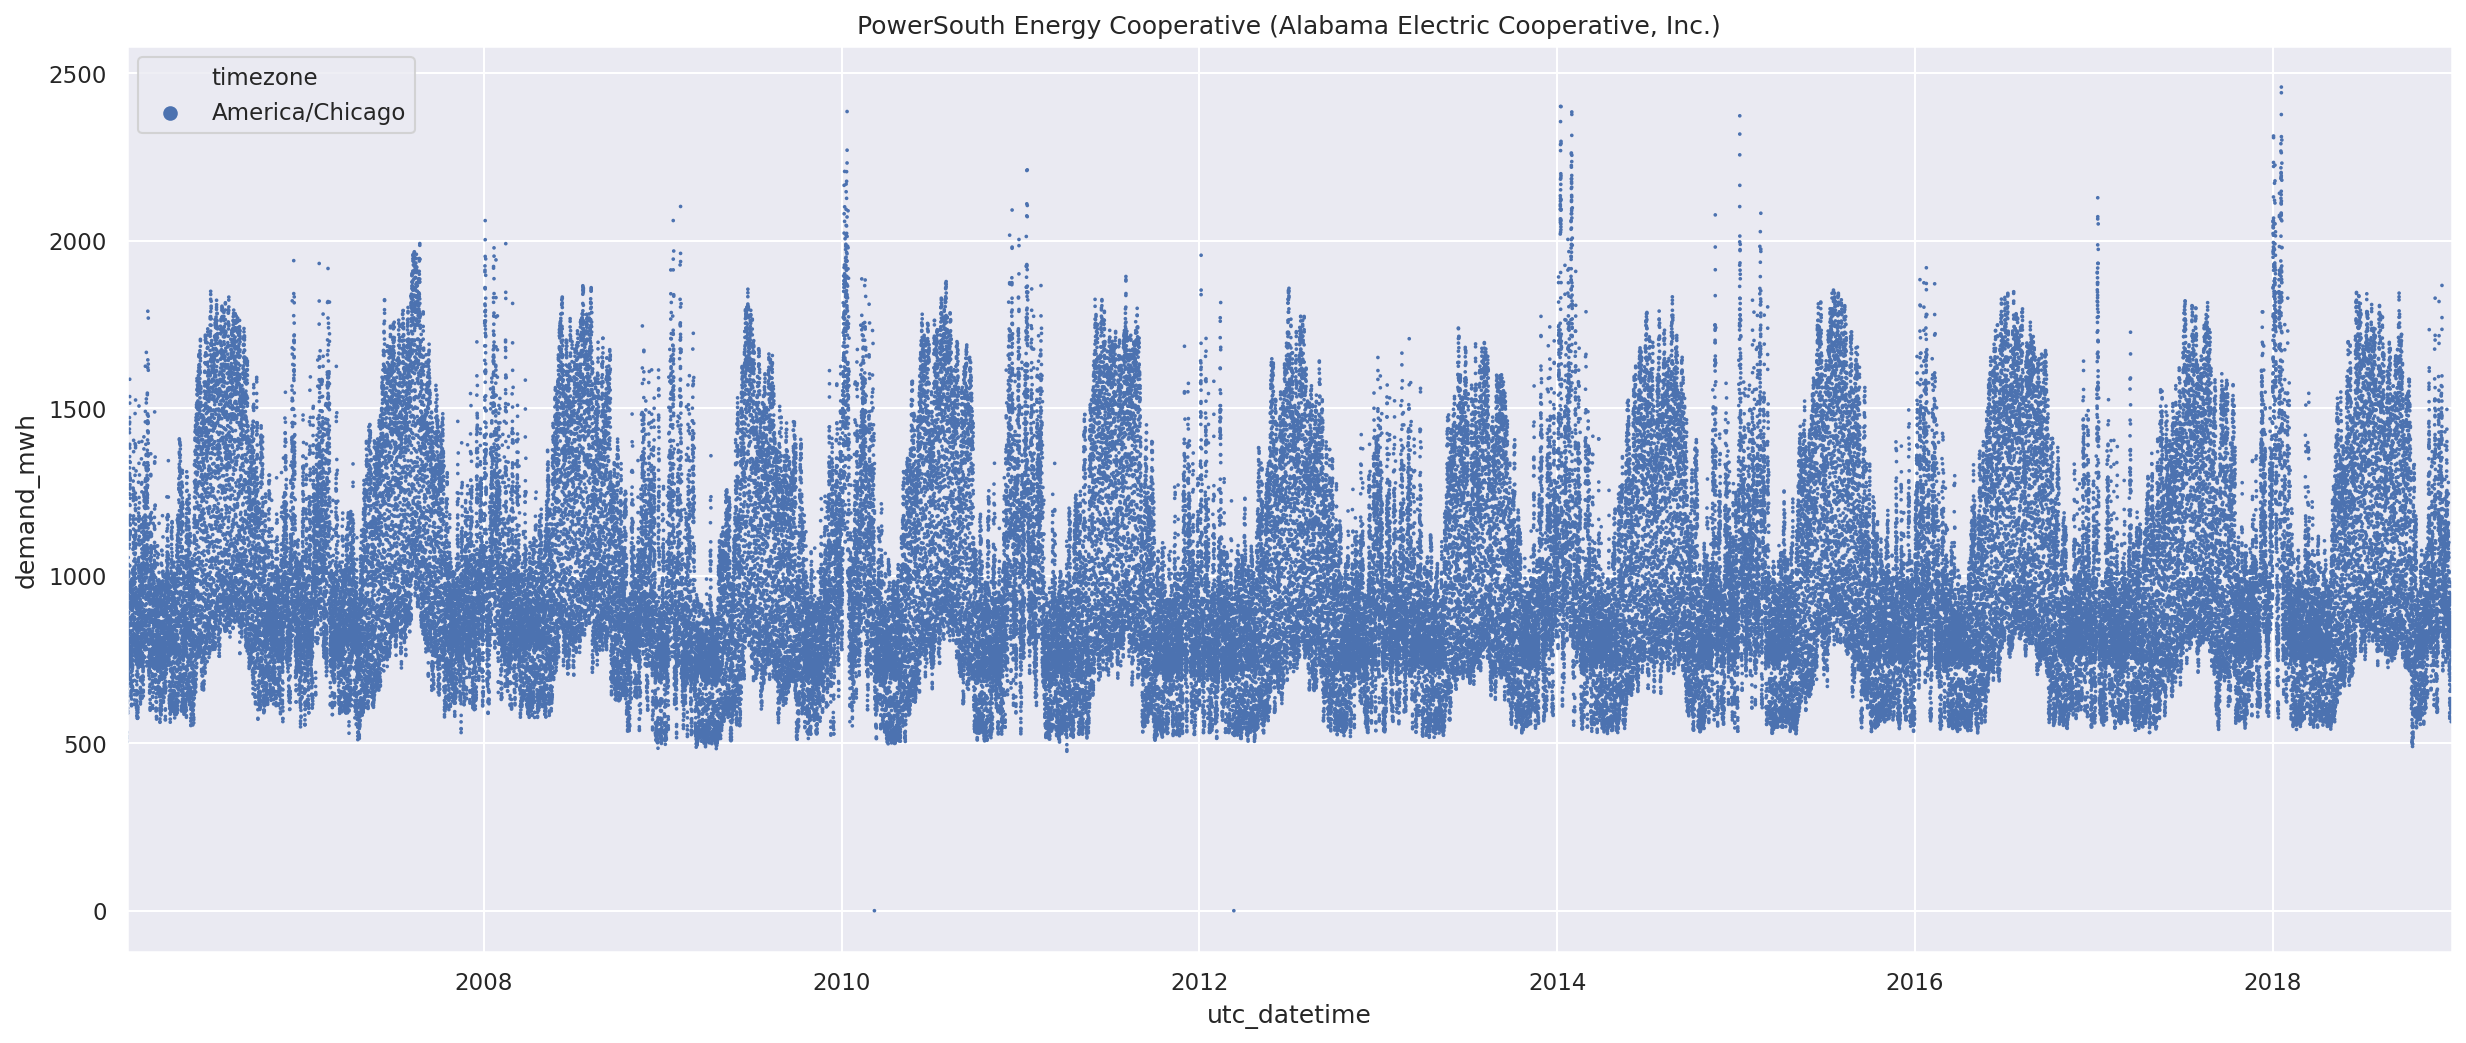

In [33]:
rid = np.random.choice(pa_demand.utility_id_ferc714.unique())
dude = pa_demand.query("utility_id_ferc714==@rid")
start_date = dude.utc_datetime.min()
end_date = dude.utc_datetime.max()
sns.scatterplot(x="utc_datetime", y="demand_mwh", hue="timezone", data=dude, s=1, edgecolor=None)
plt.title(f"{dude.utility_name_ferc714.values[0]}")
plt.xlim((start_date, end_date));

# Characterizing Unmapped Demand
These respondents have EIA IDs, but they don't show up in the HIFLD map from 2017/2018.

In [37]:
pa_geom = (
    pudl.transform.ferc714.electricity_planning_areas(pudl_settings)
    .merge(rids, left_on="ID", right_on="utility_id_eia", how="outer")
)

In [153]:
ba_eia861 = pudl.transform.eia861.balancing_authority(raw_eia861, {})["balancing_authority_eia861"]
ba_eia861.query("report_year==2018").info()

2020-05-07 14:38:19,593 [    INFO] pudl.helpers:913 Converting the dtypes of: balancing_authority_eia861
<class 'pandas.core.frame.DataFrame'>
Int64Index: 204 entries, 10521 to 10724
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   balancing_authority_code    204 non-null    string
 1   balancing_authority_id_eia  204 non-null    Int64 
 2   balancing_authority_name    204 non-null    string
 3   report_year                 204 non-null    int64 
 4   state                       204 non-null    string
 5   utility_id_eia              0 non-null      Int64 
 6   utility_name_eia            0 non-null      string
dtypes: Int64(2), int64(1), string(4)
memory usage: 13.1 KB


## Balancing Authority EIA 861
Exploration of the Balancing Authority EIA 861 table for cleanup

### Which columns are available in which years?
* **2010:** Util ID, BA ID, BA Name (3193)
* **2011:** Util ID, BA ID, BA Name (3126)
* **2012:** Util ID, Util Name, BA ID, BA Name (3146)
* **2013:** BA ID/Code/Name, State (239)
* **2014:** BA ID/Code/Name, State (208)
* **2015:** BA ID/Code/Name, State (203)
* **2016:** BA ID/Code/Name, State (203)
* **2017:** BA ID/Code/Name, State (203)
* **2018:** BA ID/Code/Name, State (204)

### What do those columns mean?
* In 2010-2012, the table says which utilities (by ID) are included in which balancing authorities.
* In 2013-2018, the table indicates which *states* a BA is operating in, and also provides a BA Code

### Questions:
* Where does the `balancing_authority_code` show up elsewhere in the EIA 860/861 data?
* Are the BA to Utility mappings likely to remain valid throughout the entire time period? Can we propagate them forward?

In [158]:
ba = ba_eia861.query("report_year==2015")
ba.query("balancing_authority_id_eia==2775")

,balancing_authority_code,balancing_authority_id_eia,balancing_authority_name,report_year,state,utility_id_eia,utility_name_eia
9933,CISO,2775,California Independent System Operator,2015,AZ,<NA>,<NA>
9934,CISO,2775,California Independent System Operator,2015,CA,<NA>,<NA>
9935,CISO,2775,California Independent System Operator,2015,NV,<NA>,<NA>


In [188]:
ba_eia861.balancing_authority_id_eia.dropna().drop_duplicates()

0         5416
1        18642
2         3265
3        14725
4        14232
         ...  
9643     29304
9789     13047
9864     59504
10164    56545
10531    15399
Name: balancing_authority_id_eia, Length: 174, dtype: Int64

In [162]:
utils_ent_eia860 = pd.read_sql("utilities_entity_eia", pudl_engine)

In [165]:
plants_eia860 = pudl_out.plants_eia860()

In [173]:
plants_eia860[plants_eia860.balancing_authority_code.notnull()].report_date.value_counts().sort_index()

2009-01-01     5747
2010-01-01     6077
2011-01-01     6357
2012-01-01     6843
2013-01-01     7656
2014-01-01     8122
2015-01-01     8521
2016-01-01     9298
2017-01-01     9679
2018-01-01    10529
Name: report_date, dtype: int64

In [172]:
plants_eia860[plants_eia860.balancing_authority_code.isnull()].report_date.value_counts().sort_index()

2009-01-01    1089
2010-01-01    1203
2011-01-01     523
2012-01-01     471
2013-01-01     432
2014-01-01     428
2015-01-01     438
2016-01-01     448
2017-01-01     482
2018-01-01     485
Name: report_date, dtype: int64

In [194]:
# BA ID comes from EIA 861 BA Table
# Util ID comes from EIA 860 Utilities Entity table.
ba_ids = set(ba_eia861.balancing_authority_id_eia)
util_ids = set(utils_eia860.utility_id_eia)
ba_not_util_ids = ba_ids.difference(util_ids)
util_not_ba_ids = util_ids.difference(ba_ids)
ba_and_util_ids = ba_ids.intersection(util_ids)

#len(plants_eia860.balancing_authority_code.unique())

In [200]:
print(f"Total # of BAs: {len(ba_ids)}")
print(f"Total # of Utils: {len(util_ids)}")
print(f"BAs that are not Utils: {len(ba_not_util_ids)}")
print(f"Utils that are not BAs: {len(util_not_ba_ids)}")
print(f"BAs that are also Utils: {len(ba_and_util_ids)}")

Total # of BAs: 175
Total # of Utils: 12017
BAs that are not Utils: 18
Utils that are not BAs: 11860
BAs that are also Utils: 157


In [222]:
ba_and_util = (
    ba_eia861
    .loc[:, ["balancing_authority_id_eia", "balancing_authority_name"]]
    .dropna(subset=["balancing_authority_id_eia"])
    .merge(
        utils_eia860,
        left_on="balancing_authority_id_eia",
        right_on="utility_id_eia",
        how="inner"
    )
    .loc[:, [
        "utility_id_eia",
        "balancing_authority_name",
        "utility_name_eia",
    ]]
    .rename(columns={"utility_id_eia": "util_ba_id"})
    .drop_duplicates()
    .reset_index(drop=True)
)

In [251]:
ba_not_util = (
    ba_eia861.loc[ba_eia861.balancing_authority_id_eia.isin(ba_not_util_ids)]
    .loc[:,["balancing_authority_id_eia", "balancing_authority_code", "balancing_authority_name"]]
    .drop_duplicates(subset=["balancing_authority_id_eia", "balancing_authority_code"])
    .sort_values("balancing_authority_id_eia")
)

In [298]:
ba_to_util_mapping = (
    ba_eia861[["balancing_authority_id_eia", "utility_id_eia"]]
    .dropna(subset=["balancing_authority_id_eia", "utility_id_eia"])
    .drop_duplicates(subset=["balancing_authority_id_eia", "utility_id_eia"])
    .groupby(["balancing_authority_id_eia"])
    .agg({
        "utility_id_eia": "count"
    })
)
util_to_ba_mapping = (
    ba_eia861[["balancing_authority_id_eia", "utility_id_eia"]]
    .dropna(subset=["balancing_authority_id_eia", "utility_id_eia"])
    .drop_duplicates(subset=["balancing_authority_id_eia", "utility_id_eia"])
    .groupby(["utility_id_eia"])
    .agg({
        "balancing_authority_id_eia": "count"
    })
)

In [300]:
util_to_ba_mapping.sort_values("balancing_authority_id_eia").sample(10)

,balancing_authority_id_eia
utility_id_eia,
4414,1
11789,1
1283,2
49848,1
13196,3
12825,1
7627,2
16177,1
20422,1


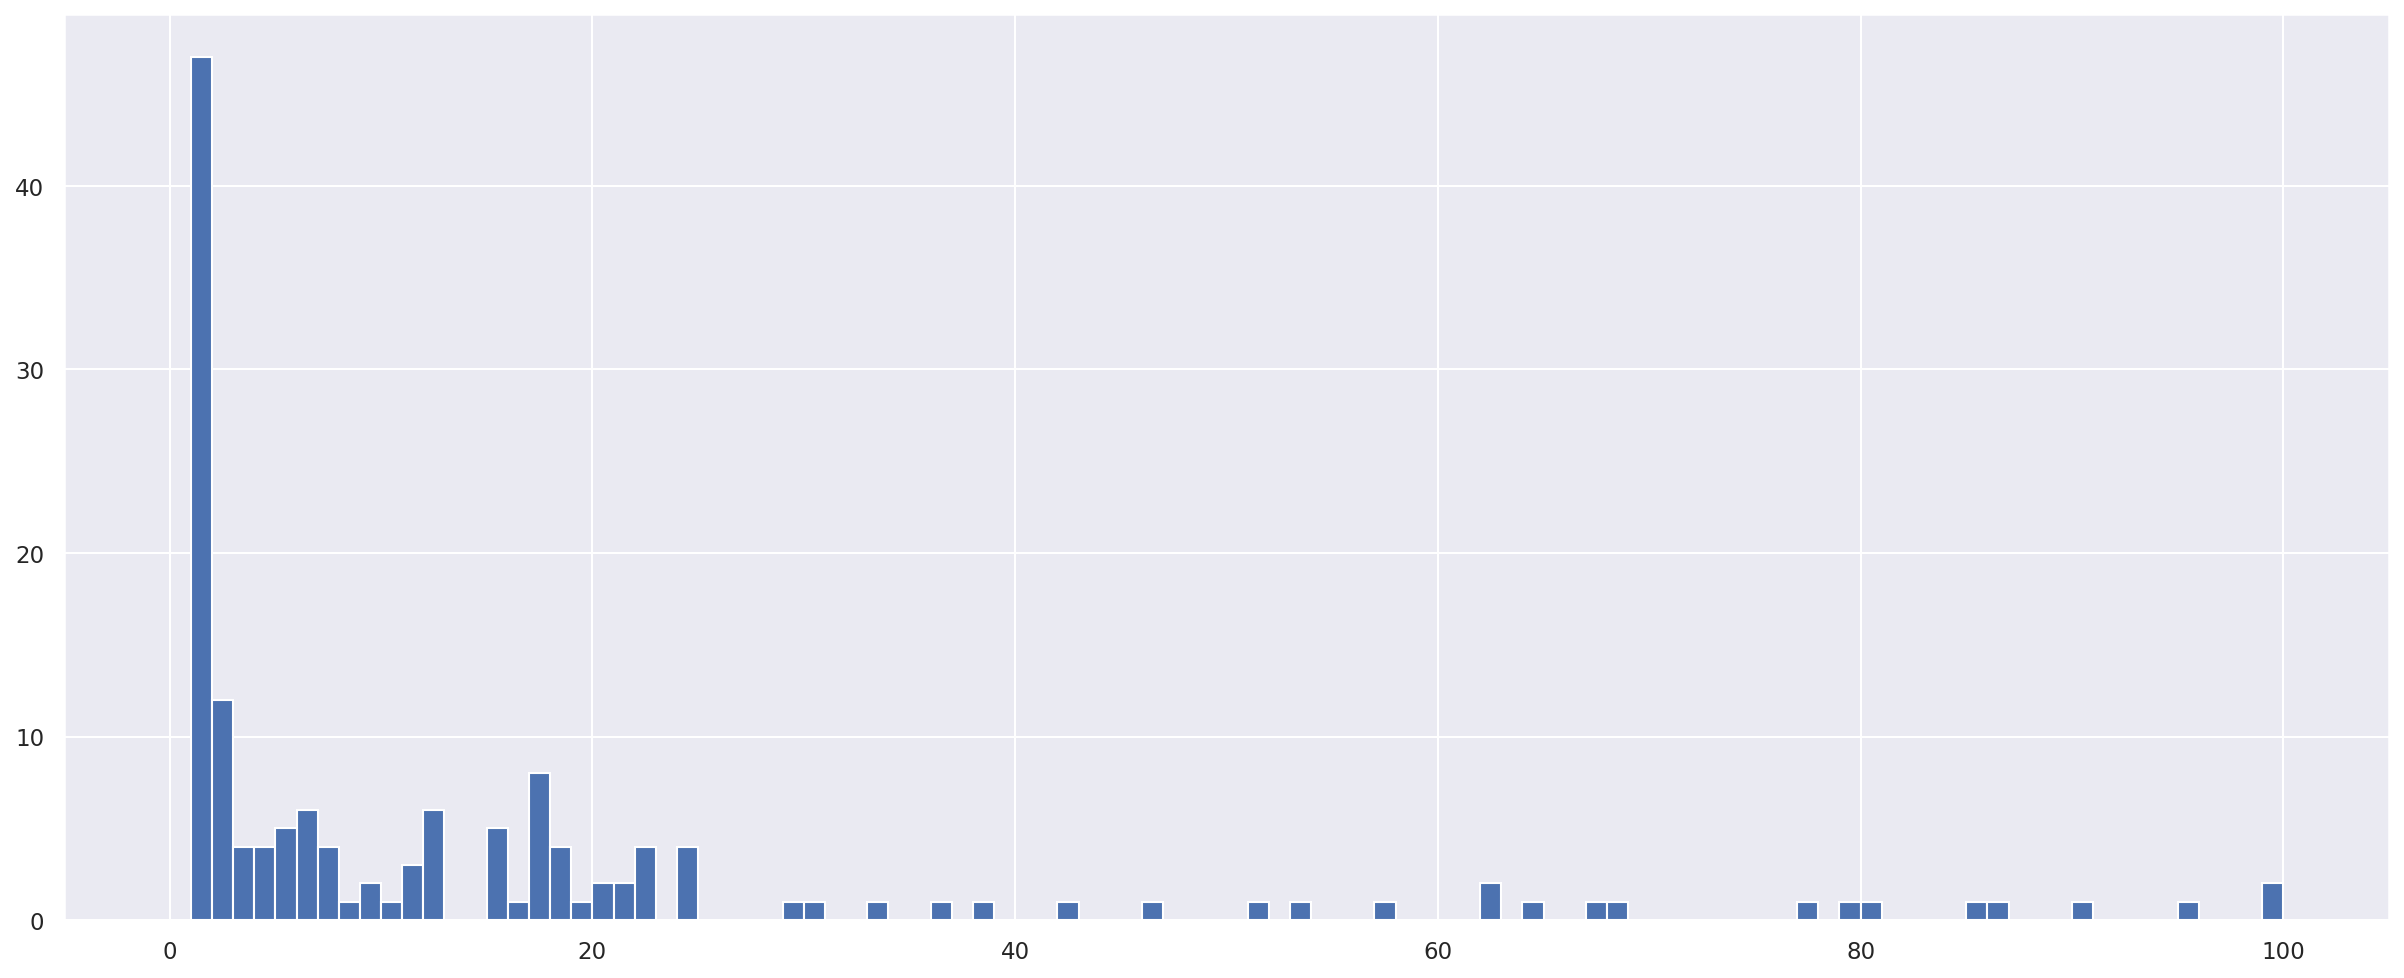

In [303]:
plt.hist(ba_to_util_mapping.utility_id_eia, bins=100, range=(0,100));

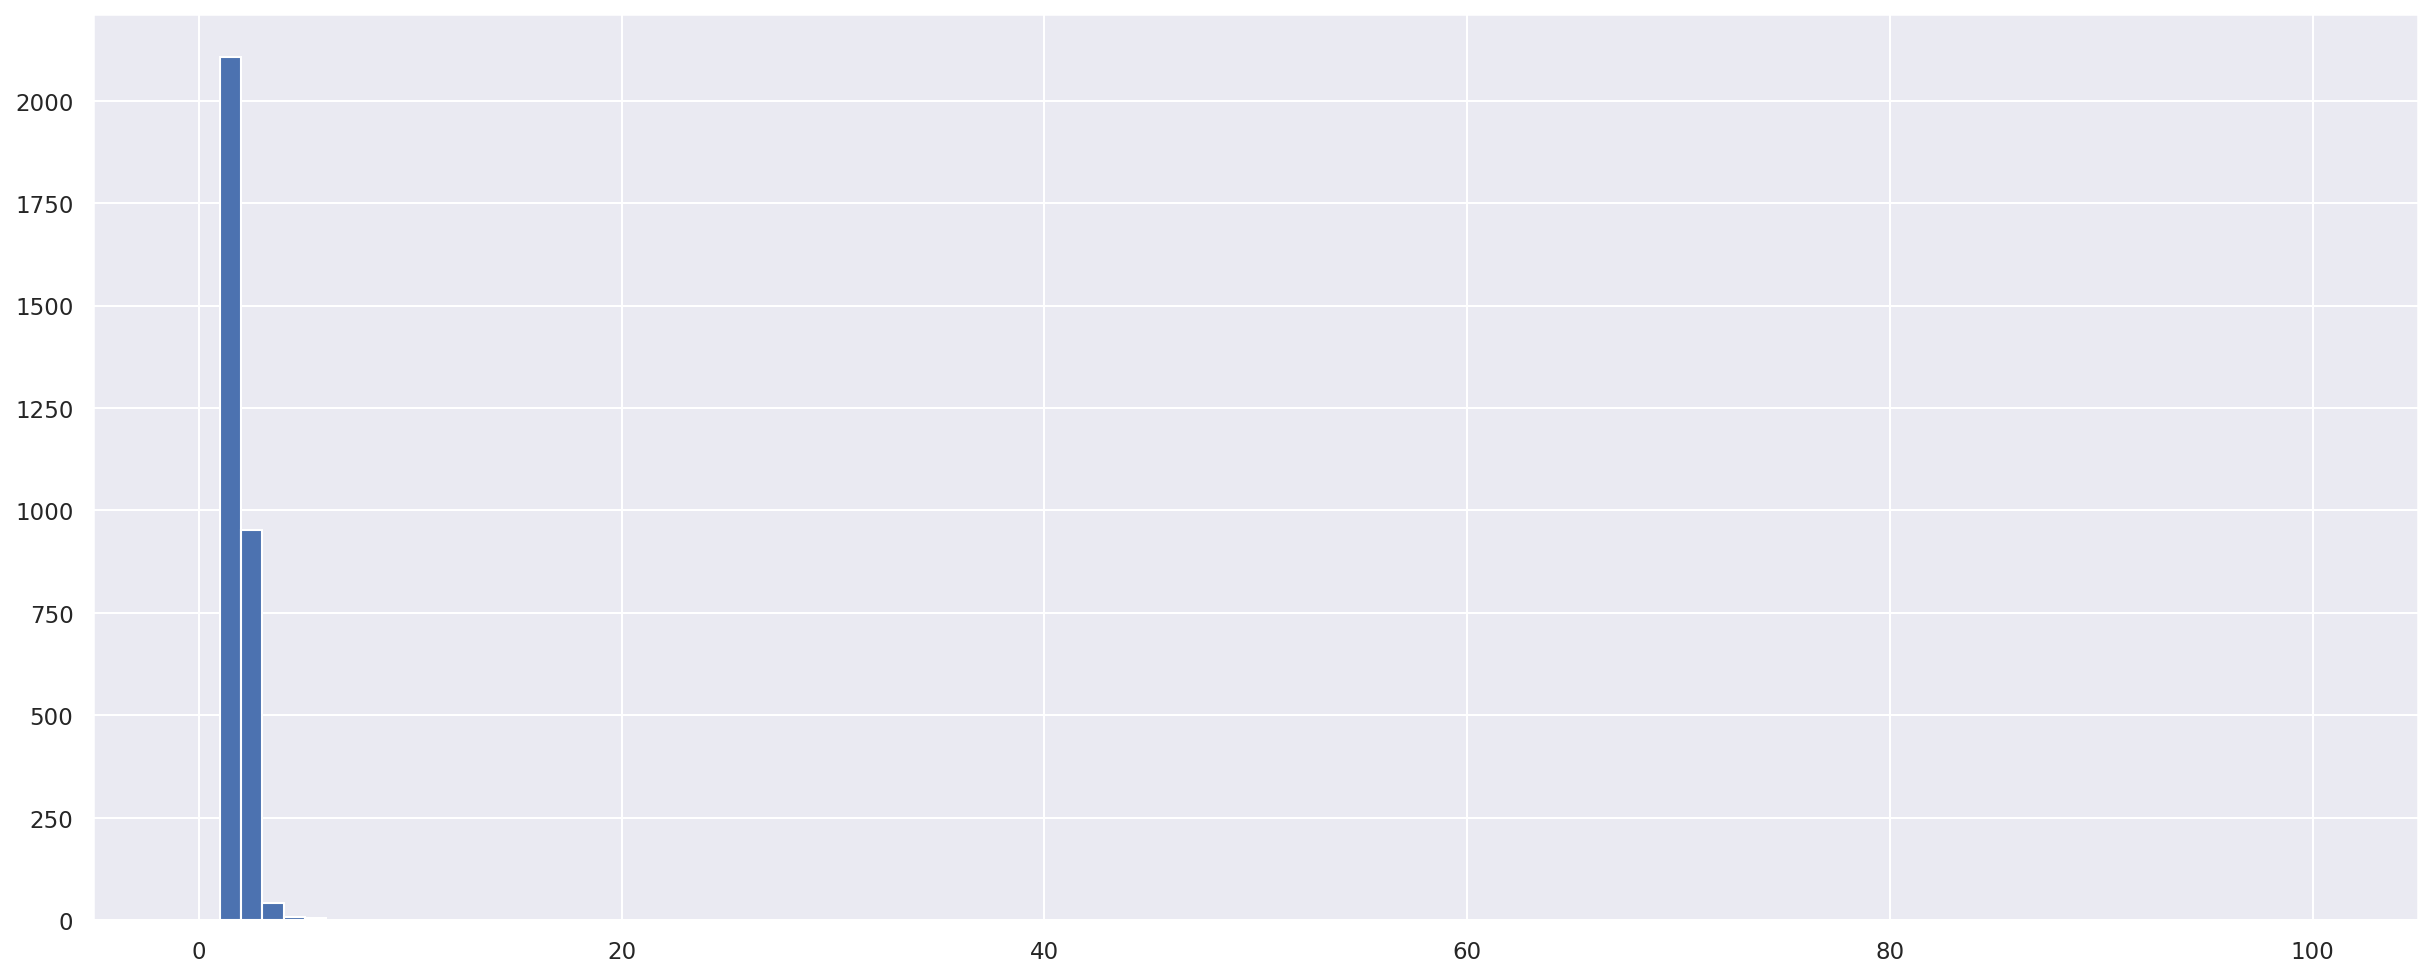

In [304]:
plt.hist(util_to_ba_mapping.balancing_authority_id_eia, bins=100, range=(0,100));

In [320]:
svc_terr.sample(20)

,county,report_year,state,utility_id_eia,utility_name_eia,state_id_fips,county_id_fips
88443,Hinds,2017,MS,12685,Entergy Mississippi Inc,28,28049
59313,Burlington,2015,NJ,963,Atlantic City Electric Co,34,34005
87739,Bienville,2017,LA,11241,Entergy Louisiana LLC,22,22013
17339,Wadena,2011,MN,12647,Minnesota Power Inc,27,27159
64116,Clayton,2015,IA,12114,City of McGregor- (IA),19,19043
81915,Trinity,2016,CA,27000,WAPA-- Western Area Power Administration,06,06105
38861,Prowers,2013,CO,8751,Town of Holly - (CO),08,08099
55459,Reagan,2014,TX,17008,Sharyland Utilities LP,48,48383
102624,Redwood,2018,MN,15793,Redwood Falls Public Util Comm,27,27127
89443,Laurens,2017,GA,13934,Ocmulgee Electric Member Corp,13,13175


In [250]:
total_sales = (
    sales_eia861
    assi.groupby(["ba_code", "state", "utility_id_eia", "report_year"])
    .agg({
        "total_customers": sum,
        "total_sales_mwh": sum,
        #"utility_name_eia": pd.DataFrame.first,
    })
)

TypeError: can only concatenate str (not "int") to str

## Missing EIA IDs
Thankfully, none of these respondents has any hourly demand associated with them.

## Calculate fraction of total demand attributable to a mapped respondent each year

In [20]:
mapped_demand = (
    pa_demand
    .groupby(["utility_id_ferc714", "report_year"]).demand_mwh.sum().reset_index()
    .merge(
        pa_geom[["utility_id_eia", "utility_id_ferc714" ]].dropna(subset=["utility_id_eia"]),
        on="utility_id_ferc714",
        how="right")
    .dropna()
    .groupby("report_year").demand_mwh.sum().reset_index()
    .astype({"report_year": int})
    .merge(
        pa_demand
        .groupby(["report_year"]).demand_mwh.sum().reset_index(),
        on="report_year", 
        suffixes=("_mapped", "_total"),
    )
    .assign(
        fraction_mapped=lambda x: x.demand_mwh_mapped / x.demand_mwh_total,
    )
)

mapped_demand

,report_year,demand_mwh_mapped,demand_mwh_total,fraction_mapped
0,2006,2.777151e+09,4.824589e+09,0.575624
1,2007,2.872959e+09,4.558935e+09,0.630182
2,2008,2.852941e+09,4.498869e+09,0.634146
3,2009,3.295141e+09,4.393668e+09,0.749975
4,2010,3.462743e+09,4.566969e+09,0.758215
5,2011,3.449786e+09,4.388848e+09,0.786034
6,2012,3.409188e+09,4.368308e+09,0.780437
7,2013,3.433462e+09,4.368202e+09,0.786013
8,2014,3.625884e+09,4.231781e+09,0.856822
9,2015,3.565045e+09,4.136113e+09,0.861931


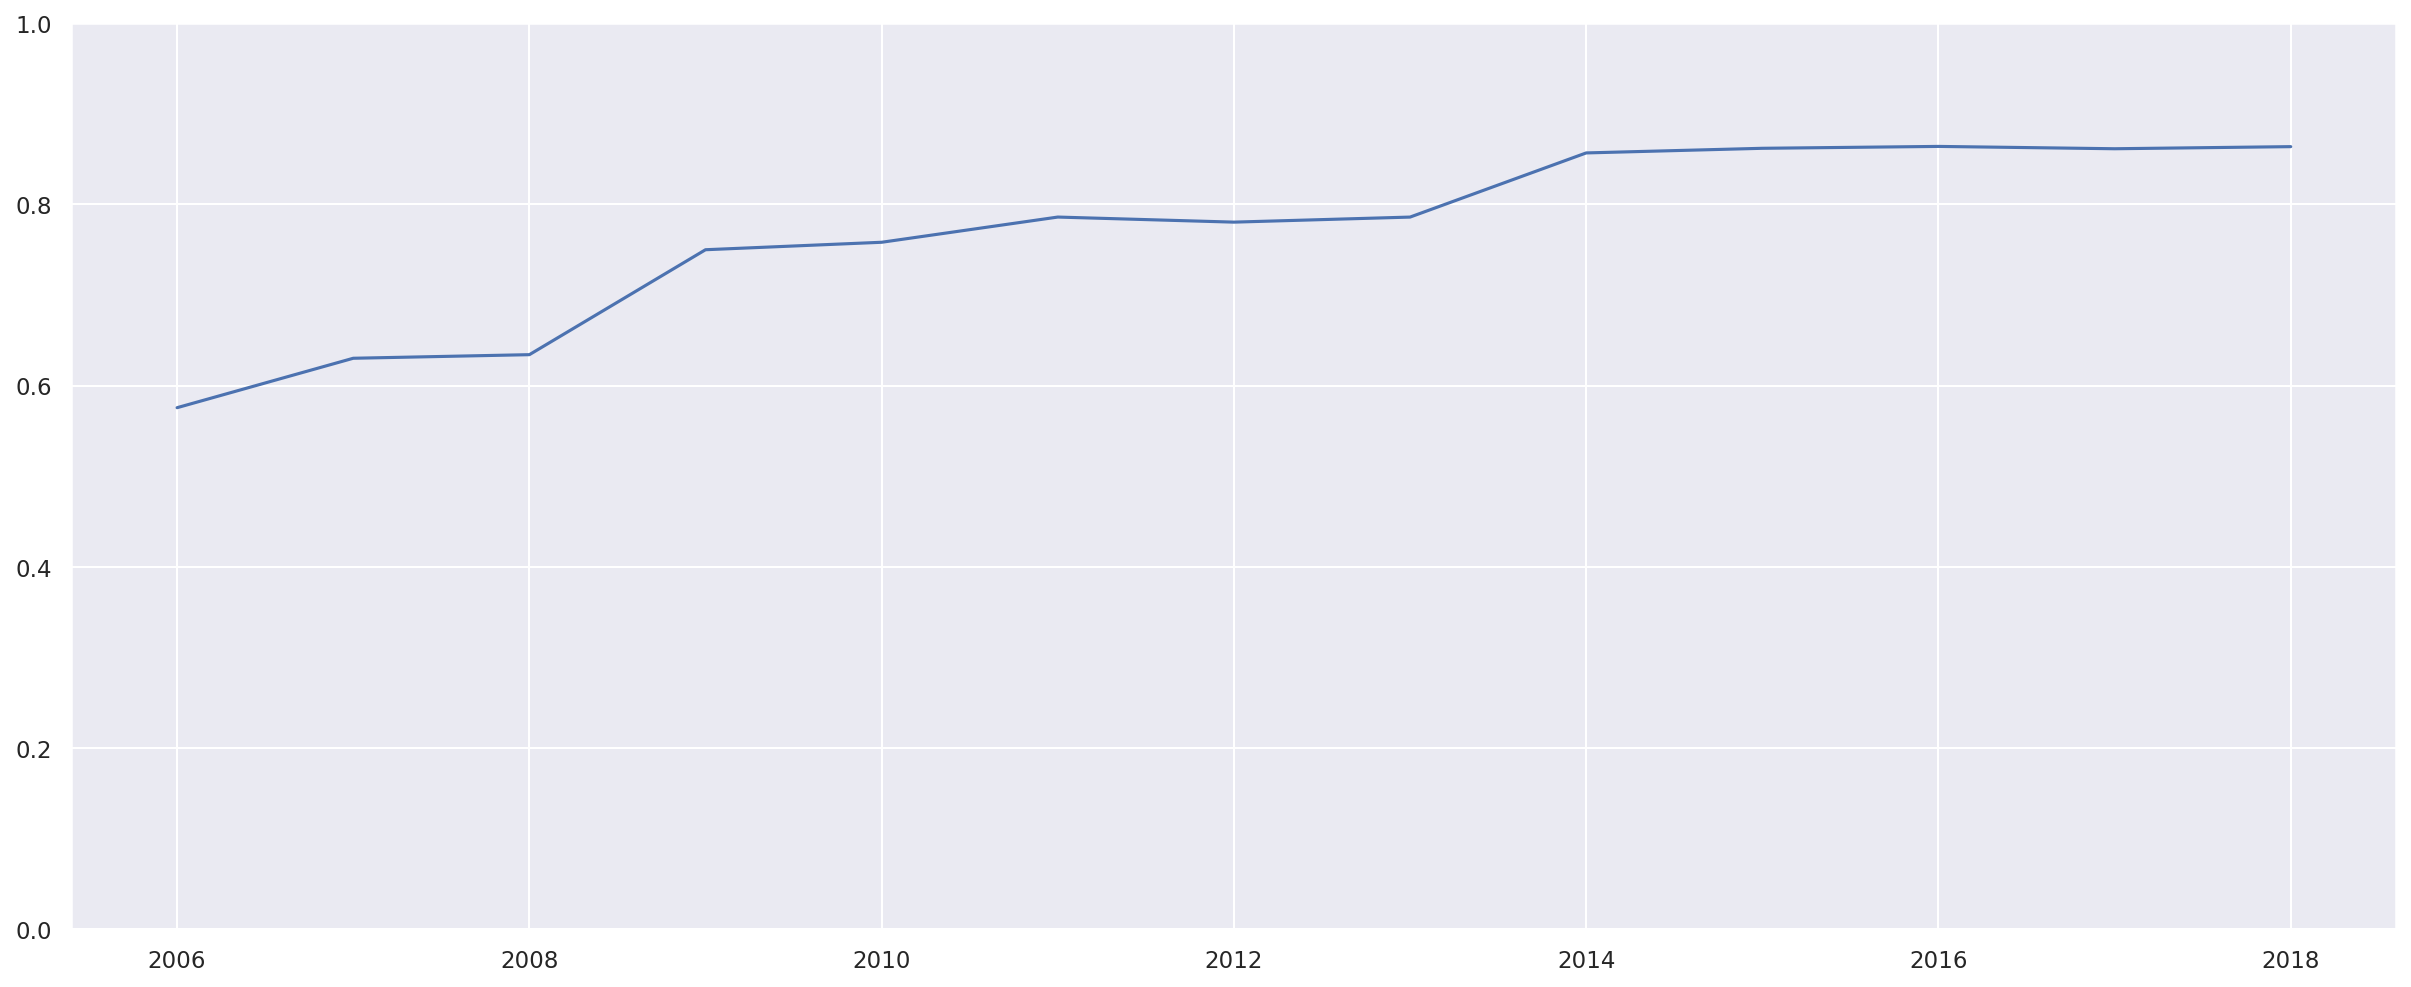

In [21]:
plt.plot(mapped_demand.report_year, mapped_demand.fraction_mapped)
plt.ylim(0, 1);

# Notes on irregularities and special cases
Unusual issues that need to be addressed, or demand discontinuities that may be useful in the context of aggregating historical demand into modern planning areas.
* Missing demand data / weird zeroes
  * 111: (2008)
  * 125: (2015)
  * 137: (2006)
  * 139: (2006) Only the last hour of every day. Maybe 0-23 vs 1-24 reporting?
  * 141: (2006, 2007, 2008, 2009, 2010)
  * 148: (2006)
  * 153: (2006)
  * 154: (2006)
  * 161: (all)
  * 183: (2007, 2009)
  * 208: (2008)
  * 273: (2007, 2008)
  * 283: (2007)
  * 287: (2008-2012)
  * 288: (2006)
  * 289: (2009)
  * 293: (2006)
  * 294: (2006)
  * 311: (2008-2011)
* Inverted Demand (Sign Errors):
  * 156: (2006, 2007, 2008, 2009)
  * 289: (2006-2008, 2010)
* Large demand discontinuities
  * 107: Demand triples at end of 2006.
  * 115: Two big step downs, 2007-2008, and 2011-2012
  * 121: 50% increase at end of 2007.
  * 128: Step up at end of 2007
  * 133: Step down end of 2013 and again end of 2015
  * 190: Demand doubled at end of 2008
  * 214: 50% jump in early 2012.
  * 256: big jump at end of 2006.
  * 261: Big jump at end of 2008.
  * 274: drop at end of 2007
  * 275: Jump at end of 2007
  * 287: Demand before and after big gap are very different.
  * 299: Big drop at end of 2015
  * 307: Jump at end of 2014
  * 321: Jump at end of 2013